# Terahertz Conversion Effeciency

Using a model that accounts for cascaded optical rectification, three-photon absorption of the near-infrared radiation, and material dispersion/absorption properties, we describe the Terahertz generation through optical rectification of near-infrared femtosecond pulses in DSTMS.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

from optical_rectification import definitions, propagator, run, par

# constants
c = 299792458.0  # speed of light [m/s]
c_thz = c * 1e-12  # [m * THz]
EPS0 = 8.85e-12  # vacuum permitivity [C^2 / Kg^1 / m^3 /s^2]

## The Input Gaussian Pulse

The intensity profile of the input Gaussian pulse is
\begin{equation}
    I(t) = \frac{cn\epsilon_0}{2} \vert E_0 \vert^2 \exp[ -2t^2/\tau^2 ],
\end{equation}
with $c$, $\epsilon_0$, and $n$ as the speed of light in vacuum, permittivity of free space, and
refractive index of the medium, respectively. The full width at half-maximum FWHM, ${\Delta}t = 0.075 \: ps$, of the Gaussian wave packet in the time domain, defines $\tau$, such that
\begin{equation}
    \tau = \frac{\sqrt{2}{\Delta}t}{{2\sqrt{{\rm ln}(2)}}}.
\end{equation}
Noting that $I(t) \propto \vert E(t) \vert^2$, the electric field is given by 
\begin{equation}
    E(t) = E_0 \exp[ -t^2/\tau^2 ] e^{-i \omega_0 t}.
\end{equation}
where $\omega_0$ is the carrier-wave frequency.

Applying the Fourier Transfrom $\mathcal{F}$ yields the field distribution in the frequency domain
\begin{equation}
\begin{split}
    E(\omega) &= \mathcal{F}\{ E(t) \}
    \\
    &= E_0\sqrt{\pi}\tau \exp[ - \Delta^2/\delta^2 ],
\end{split}
\end{equation}
where $\Delta = \omega_0 - \omega$, and $\delta=2/\tau$. Thus the spectral intensity is
\begin{equation}
    I(\omega) = \frac{cn\epsilon_0}{2} \vert E_0 \sqrt{\pi}\tau \vert^2 \exp[ - 2\Delta^2/\delta^2 ].
\end{equation}
This yields the FWHM in the frequency domain, i.e. the bandwith $\Delta\omega$, such that
\begin{equation}
    \Delta\omega = \frac{\delta}{\sqrt{2}}2\sqrt{{\rm ln}(2)}.
\end{equation}
This result yields the well known time-bandwidth product of a Fourier transform–limited pulse, such that
\begin{equation}
\begin{split}
    {\Delta}t{\Delta}\nu &= \frac{{\Delta}t{\Delta}\omega}{2\pi}
    \\
        &= \frac{\tau\delta}{2\pi\left(\sqrt{2}\right)^2}4{\rm ln}(2)
    \\
        &= 0.441.
\end{split}
\end{equation}

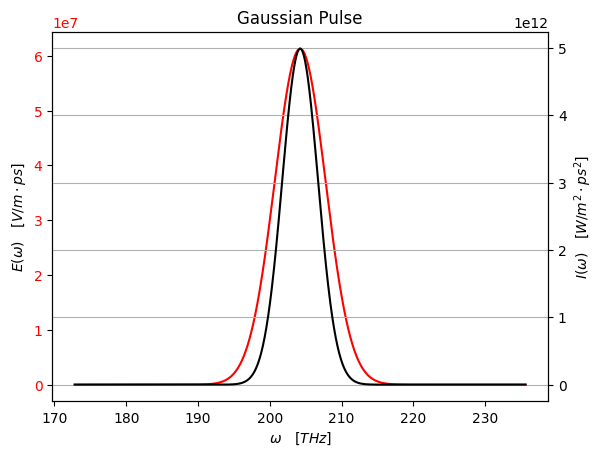

The pulse bandwith is  5.883616004070708 THz


In [2]:
# Example Gaussian Pulse
w0 = c_thz / 1468e-9  # [THz]
t_fwhm = 75e-15 * 1e12  # [ps]
E0 = 5.4315195283 * 1e8  # [V/m]
pulse = definitions.Gaussian(w0=w0, t_fwhm=t_fwhm, E0=E0, Nw=2**10)
w_fwhm = pulse.delta * np.sqrt(2*np.log(2)) / (2 * np.pi)

fig1, ax = plt.subplots()
ax.plot(pulse.w, pulse.field_w(), 'r')
ax.set_title("Gaussian Pulse")
ax.set_xlabel(r"$\omega \quad [THz]$")
ax.set_ylabel(r"$E(\omega) \quad [V/m\cdot ps]$")
ax.tick_params(axis='y',labelcolor='r')
ax1 = ax.twinx()
ax1.plot(pulse.w, (EPS0*c/2)*np.abs(pulse.field_w())**2, 'k')
ax1.set_ylabel(r"$I(\omega) \quad [W/m^2 \cdot ps^2]$")
ax1.tick_params(axis='y',labelcolor='k')

plt.grid(True)
plt.show()
print("The pulse bandwith is ", w_fwhm, "THz")

## Field Correlation in Terahertz

The $\chi^2$ nonlinearity induces frequency mixing of the input pulse $E(\omega)$ in the terahertz region $\Omega$, where $\omega < \Omega$. This yields correlation terms of the form
\begin{equation}
    C(\Omega) = \int_0^{\infty} d\omega \: E(\omega+\Omega) E^{*}(\omega).
\end{equation}
We approximate $C(\Omega) \approx C(k)$; $C(k)$ is the Reiman sum
\begin{equation}
    C(k) = \Delta\omega \sum_{n=0}^{N-k-1} E(\omega_{n+k}) E^{*}(\omega_n),
\end{equation}
where $\omega_n = n\Delta\omega$, $\Omega_k = k\Delta\omega$, so that $\omega_{n+k} = \omega_n + \Omega_k$. Here $N\rightarrow\infty$ for $E(\omega_N) \rightarrow 0$.
The code below implements $C(k)$, for a field $E(\omega)$ with a Gaussian envelop as described in the above section.

0.061383383383002865


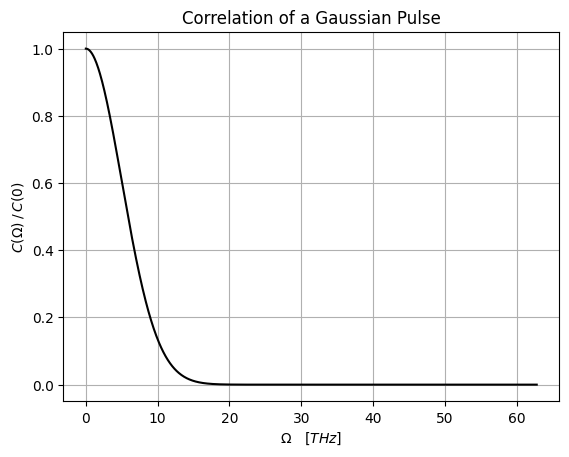

In [3]:
# variables
dw = abs(pulse.w[1] - pulse.w[0])                     # freq per grid spacing
print(dw)
# N = len(pulse.w);
n_dps = int( ( max(pulse.w) - min(pulse.w) ) / dw )    
N = n_dps + 1
Ω = np.linspace(0, n_dps, n_dps + 1) * dw

perseval_pref = np.sqrt(  
    np.pi / (8 * np.pi**2 / pulse.delta**2) 
)
norm = perseval_pref * abs(pulse.E0_w)**2

chi2_mixing = definitions.Chi2_mixing(
    pulse.field_w(), dw, N
)
C_m = chi2_mixing.correlation()

fig2, ax2 = plt.subplots()
ax2.plot(Ω, C_m.real / norm, 'k')
ax2.set_title("Correlation of a Gaussian Pulse")
ax2.set_xlabel(r"$\Omega \quad [THz]$")
ax2.set_ylabel(r"$C(Ω) \: / \: C(0)$")
ax2.tick_params(axis='y',labelcolor='k')
plt.grid(True)

## Refractive Index and Absorption Properties 

1. Using Lorentz model, we interpolate the refractive index of the nonlinear optical crystal (DSTMS) in the THz range. The oscillator parameters are based on the data extracted from "Montemezzani, G. et al. J. Opt. Soc. Am. B 32, 1078-1083 (2015)"
2. Using Sellmeier model, we interpolate the refractive index of the nonlinear crystal in the optical range. The parameters are based on the data extracted from "[]"

196


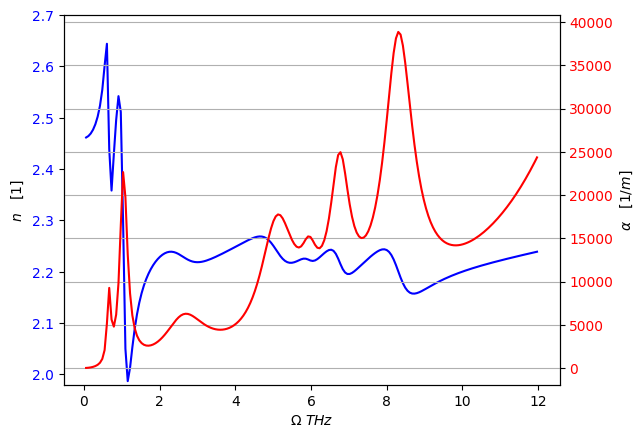

In [4]:
# Visualize refractive index in THz region
fig3, ax3 = plt.subplots()

Ω_max = 12; m_dps = int(Ω_max / dw)
NΩ = m_dps + 1
mvals = np.linspace(1, m_dps, NΩ); print(len(mvals))
Ω = mvals * dw

index_Ω = definitions.Index(Ω)

ax3.plot(Ω, index_Ω.n(), 'b')
ax3.set_xlabel(r'$\Omega$ $THz$')
ax3.set_ylabel(r"$n \quad [1]$")
ax3.set_ylim(1.98, 2.7)
ax3.tick_params(axis='y',labelcolor='b')
ax4 = ax3.twinx()  # Create a second axes object that shares the same x-axis
ax4.plot(Ω, index_Ω.alpha(), 'r')
ax4.set_ylabel(r"$\alpha \quad [1/m]$")
ax4.tick_params(axis='y',labelcolor='r')
plt.grid(True)

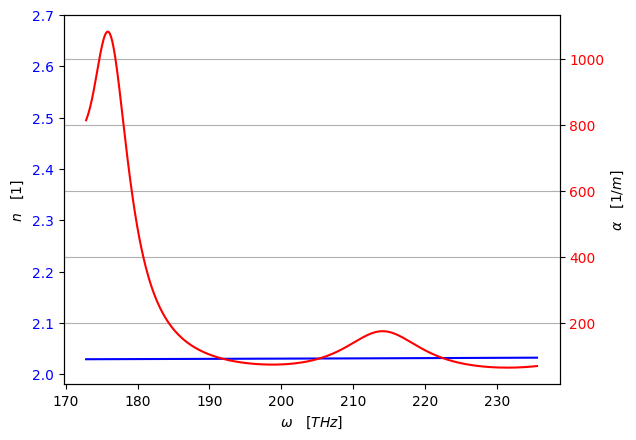

In [5]:
# Visualize refractive index in Optical region
fig5, ax5 = plt.subplots()

index_w = definitions.Index(pulse.w, param=par.param_op, k=1)

ax5.plot(pulse.w, index_w.sellmeier(), 'b')
ax5.set_xlabel(r'$\omega \quad [THz]$')
ax5.set_ylabel(r"$n \quad [1]$")
ax5.set_ylim(1.98, 2.7)
ax5.tick_params(axis='y',labelcolor='b')
ax5b = ax5.twinx()  
ax5b.plot(pulse.w, index_w.alpha(), 'r')
ax5b.set_ylabel(r"$\alpha \quad [1/m]$")
ax5b.tick_params(axis='y',labelcolor='r')
plt.grid(True)

## Dispersion and Phase Matching Condition

Noting that the dispersion relation is given by 
\begin{align}
    k(\omega) &= \omega \frac{n(\omega)}{c}
    \\
    k(\Omega) &= \Omega \frac{n(\Omega)}{c}
\end{align}
where $n(\omega)$ and $n(\Omega)$ is the refractive index in the optical and terahertz region, respectively, of the nonlinear crystal defined above. For optical rectification the phase matching term is defined by
\begin{equation}
    {\Delta}k = k(\omega + \Omega) - k(\omega) - k(\Omega).
\end{equation}
Since $\Omega \ll \omega$ we make the approximation that
\begin{equation}
\begin{split}
    k(\omega + \Omega) - k(\omega) &\approx \Omega \frac{{\rm d}k(\omega)}{{\rm d}\omega}
    \\
    &= \Omega \frac{n_g(\omega)}{c},
\end{split}
\end{equation}
where $n_g(\omega)$ is the group velocity. Also note that since $\omega_1 - \omega_2 = \Omega$, and 
$\Omega \ll \omega_{1,2}$, then $\omega_{1,2} \approx \omega_0$, so that $n_g(\omega) \rightarrow n_g(\omega_0)$. 

Thus
\begin{equation}
    {\Delta}k \approx \frac{\Omega}{c} \left[ n_g(\omega_0) - n(\Omega) \right].
\end{equation}

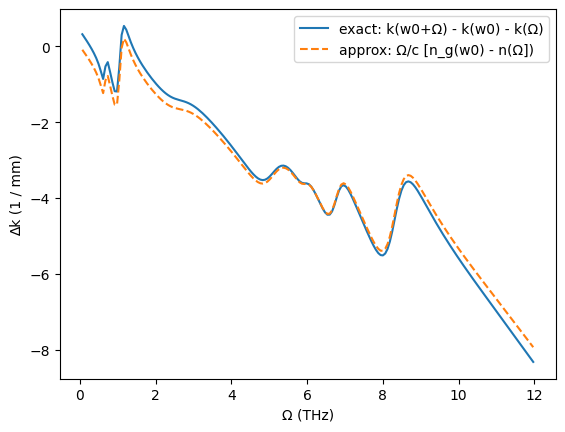

0.40988456747342294


In [6]:
# phase-match dispersion
dispersion = definitions.Dispersion(
    pulse.w, index_w.sellmeier(), Ω=Ω, n_Ω=index_Ω.n()
)

# graph
iw0 = np.argmin(np.abs(pulse.w - w0))
# fig6, (ax6, ax6b) = plt.subplots(nrows=1, ncols=2)
fig6, ax6 = plt.subplots()
ax6.set_xlabel("Ω (THz)")
ax6.set_ylabel("∆k (1 / mm)")
ax6.plot(Ω, dispersion.phase_match()[iw0, :] * 1e-3, label="exact: k(w0+Ω) - k(w0) - k(Ω)")
ax6.plot(Ω, dispersion.deltak()[iw0, :] * 1e-3, "--", label="approx: Ω/c [n_g(w0) - n(Ω])")
ax6.legend()
plt.show()
print(abs(dispersion.deltak()[iw0, :][0] - dispersion.phase_match()[iw0, :][0])*1e-3)


We note that the error in the approximation $\mathcal{E}({\Delta}k)$ is $\pm 3.34 \: {\rm mm}^{-1}$ when $\Omega = 10-12$ THz. So that for a crystal with depth of about $1 - 2$ mm, the error accumulated in the phase difference is 
\begin{equation}
    {\Delta}k \cdot L = \phi \pm 6.68 \:\: {\rm mm}.
\end{equation}
Here the approximation is no longer valid since $\left\vert \frac{\mathcal{E}({\Delta}k)}{\phi} \right\vert \ge 1$. Thus the approximation $Δk ≈ Ω(n_g − n_Ω)/c$ is only valid for $Ω \ll$ optical bandwidth $\delta = 35$ THz. From the graph above, it is valid at  $Ω < 1.5$ THz.

## Field Mixing due to $\chi^{(2)}$ Nonlinearity

This takes the form
\begin{equation}
    C(\Omega) = i\mathcal{E}^{-1} \int_0^{\infty} {\rm d}\omega \: E(\omega+\Omega) E^{*}(\omega) 
        \exp{[ -i z {\Delta}k(\omega, \Omega) ]},
\end{equation}
where ${\Delta}k(\omega, \Omega)$ is the phase matching condition defined above. The Reinmann sum approximation as discussed above is
\begin{equation}
    C(\Omega_m) = i\mathcal{E}^{-1} \Delta\omega \sum_{n=0}^{N-m-1} E(\omega_{n+m}) E^{*}(\omega_n)
        \exp{[ -i z {\Delta}k(\omega_n, \Omega_m) ]}.
\end{equation}

In [7]:
# visualize normalized chi2 mixing
np.seterr(invalid='ignore', divide='ignore')

zvals = np.array( [0, 0.1, 0.2, 0.3, 0.4] ) * 1e-3
Dk = dispersion.phase_match()
C_zm = np.zeros((len(zvals), Dk.shape[1]), dtype=complex)

for i, z in enumerate(zvals):
    C_zm[i, :] = 1j * definitions.Chi2_mixing(
        pulse.field_w(), dw, NΩ, Dk_up=Dk, z=z
    ).correlation()

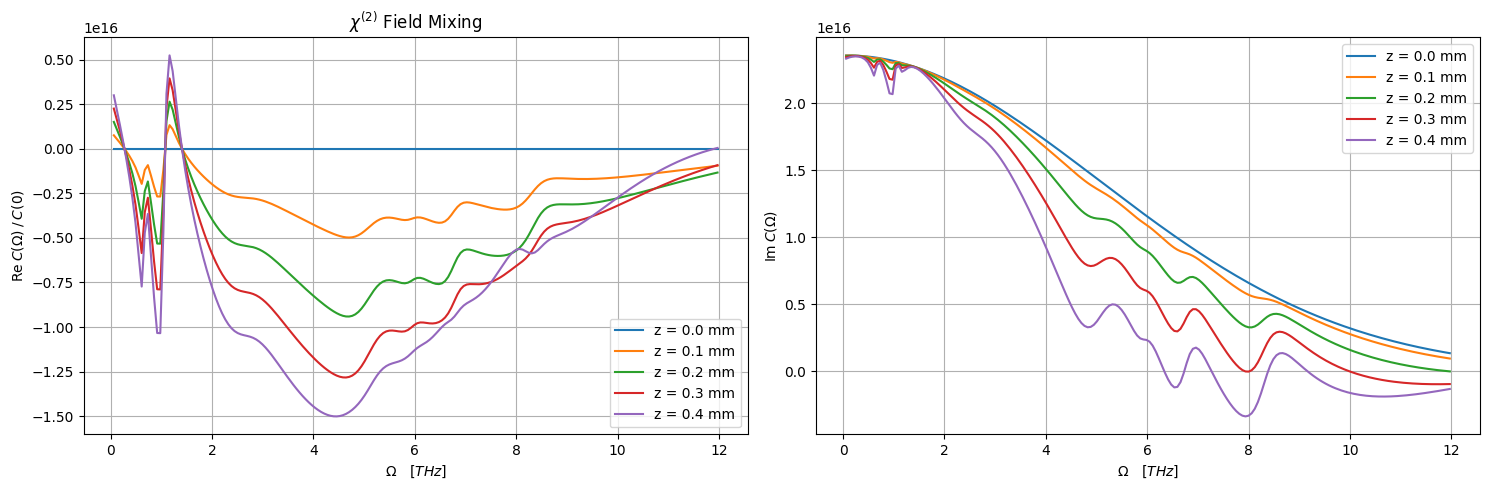

In [8]:
fig7, (ax7, ax8) = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

for i, z in enumerate(zvals):
    ax7.plot(Ω[:], C_zm.real[i, :], label='z = '+str(z*1e3)+' mm')
    ax8.plot(Ω[:], C_zm.imag[i, :], label='z = '+str(z*1e3)+' mm')

ax7.set_title(r"$\chi^{(2)}$ Field Mixing")
ax7.set_xlabel(r"$\Omega \quad [THz]$")
ax7.set_ylabel(r"${\rm Re} \: C(Ω) \: / \: C(0)$")
ax7.legend()
ax7.grid(True)
ax8.set_xlabel(r"$\Omega \quad [THz]$")
ax8.set_ylabel(r"${\rm Im} \: C(Ω)$")
ax8.legend()
ax8.grid(True)
plt.tight_layout()

The $\chi^{(2)}$ mixing prefactor is defined as
\begin{equation}
    \mathcal{E}^{-1} = \frac{ \Omega^2 \chi^{(2)}_{\rm eff} }{c^2 k(\Omega) }
\end{equation}
which has units of inverse volts. The graph below shows the unormalized nonlinear mixing term 
${\rm Re} \{ C(\Omega) \}$:

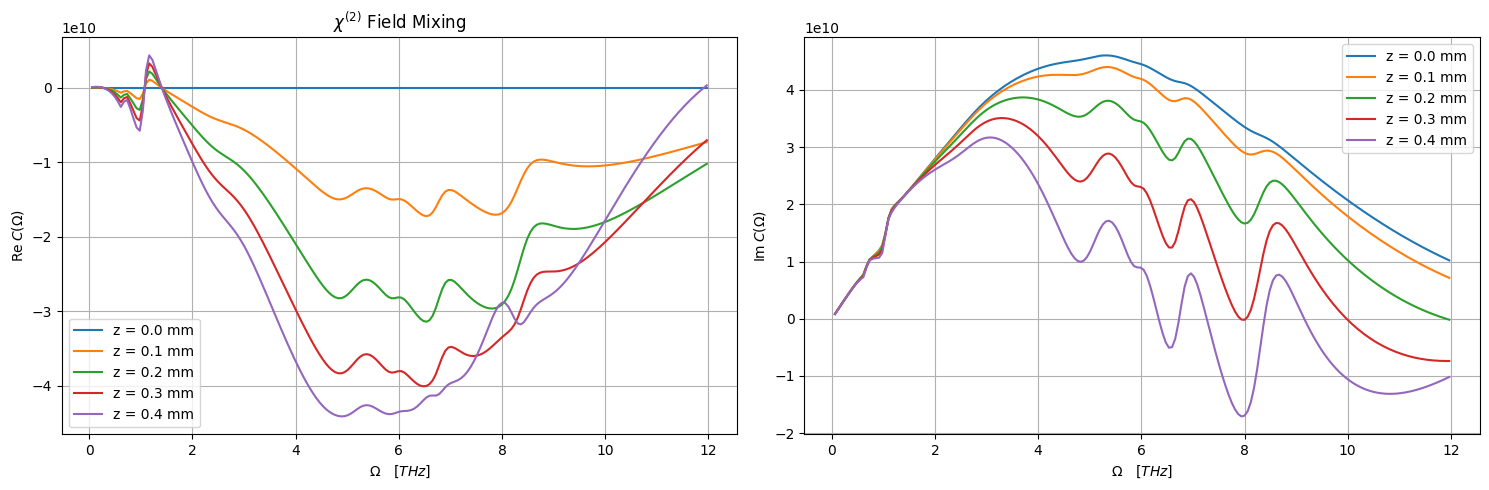

In [9]:
# visualize chi2 mixing
fig9, (ax9a, ax9b) = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

pref = definitions.chi2_factor(Ω, dispersion.k_Ω)
for i, z in enumerate(zvals):
    ax9a.plot(Ω[:], (pref[:] * C_zm.real[i, :]), label='z = '+str(z*1e3)+' mm')
    ax9b.plot(Ω[:], (pref[:] * C_zm.imag[i, :]), label='z = '+str(z*1e3)+' mm')
    
ax9a.set_title(r"$\chi^{(2)}$ Field Mixing")
ax9a.set_xlabel(r"$\Omega \quad [THz]$")
ax9a.set_ylabel(r"${\rm Re} \: C(Ω)$")
ax9a.legend()
ax9a.grid(True)
ax9b.set_xlabel(r"$\Omega \quad [THz]$")
ax9b.set_ylabel(r"${\rm Im} \: C(Ω)$")
ax9b.legend()
ax9b.grid(True)
plt.tight_layout()

## OR Propagator model

In [10]:
# --- propagation model ---
# model = propagator.ORPropagator(pulse, Ω_max, NΩ, cascade=True)
# --- solver ---
output = run.or_simulation(
    w0=w0, t_fwhm=t_fwhm, E0=1.2*5.4315e8,
    Ω_max=Ω_max, NΩ=NΩ,
    depth=zvals[-2], cascade=True
)

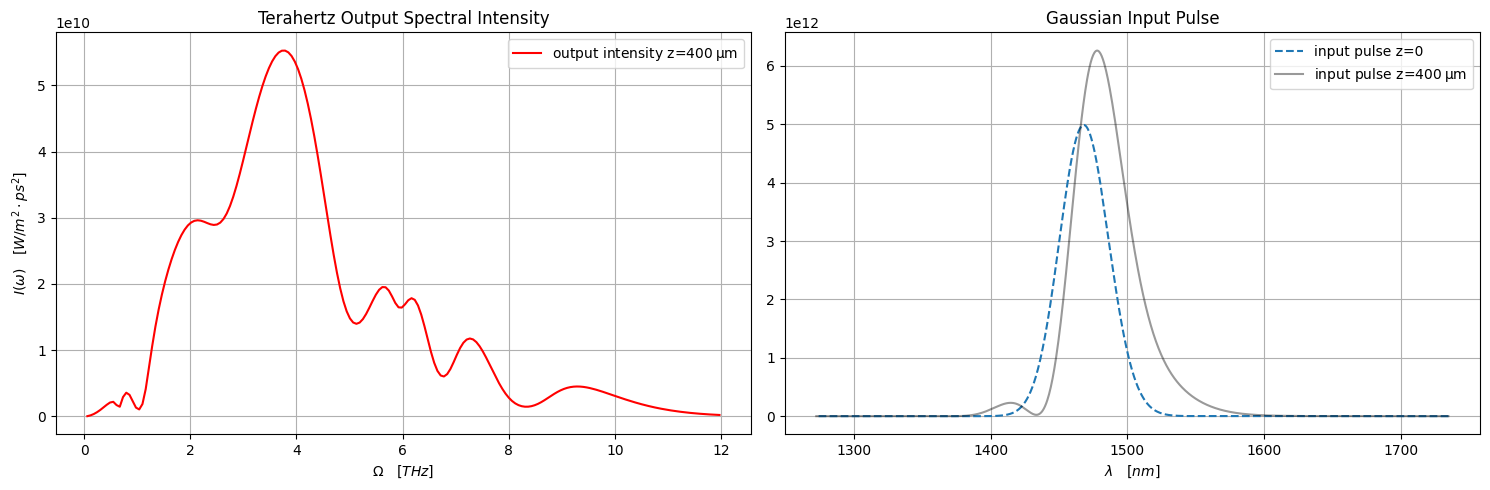

In [11]:
# visualize Field Output
fig10, (ax10, ax11) = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax11.plot(c_thz/pulse.w * 1e9, (EPS0 * c / 2)*np.abs(pulse.field_w())**2, '--', 
          label=r'input pulse z=0')
ax11.plot(c_thz/pulse.w * 1e9, (EPS0 * c / 2)*np.abs(output["Ew"])**2, 'k', 
          alpha=0.4, label=r'input pulse z=$400 \: {\rm {\mu}m}$')
ax11.set_title(r"Gaussian Input Pulse")
ax11.set_xlabel(r"$\lambda \quad [nm]$")
ax11.legend()
ax11.grid(True)

ax10.plot(output["model"].Ω, (EPS0 * c / 2)*np.abs(output["EΩ"])**2, '-r', 
          label=r'output intensity z=$400 \: {\rm {\mu}m}$')
ax10.set_title(r"Terahertz Output Spectral Intensity")
ax10.set_xlabel(r"$\Omega \quad [THz]$")
ax10.set_ylabel(r"$I(\omega) \quad [W/m^2 \cdot ps^2]$")
ax10.legend()
ax10.grid(True)

plt.tight_layout()